In [1]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras


2023-04-05 12:08:22.982654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 12:08:23.187747: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-05 12:08:27.372915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 12:08:27.493540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 12:08:27.493887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
#TODO document jupyter
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np

configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'

con = sl.connect(datasetPathDatabase)
data = con.execute("SELECT V.ID, V.VIDEO_PATH, V.AGE, V.ETHNICITY, V.GENDER, A.SPEAKER_EMB, A.LANG, F.FACE_PATH, 'The face of a person ' CAPTION  FROM VIDEO V INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID INNER JOIN FACE F ON V.ID = F.VIDEO_ID LIMIT 50000 OFFSET 0")
dataGotten = data.fetchall()

pd.set_option('display.max_columns', None)
df = pd.DataFrame(dataGotten,columns = ['ID','VIDEO_PATH','AGE','ETHNICITY','GENDER','SPEAKER_EMB','LANG','image_path','caption'])

def speaker_emb_preprocess(speaker_emb2):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    #if maxlen is None: maxlen = tokenizer.model_max_length
    #inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    #return text_encoder(inp.input_ids.to("cuda"))[0].half()

    #speaker_emb2 = speaker_emb2.squeeze()
    speaker_emb2 = pickle.loads(speaker_emb2)
    #print(speaker_emb2.shape)
    speaker_emb2 = speaker_emb2.squeeze()
    speaker_emb2 = np.pad(speaker_emb2, (288), 'constant', constant_values=(0))
    #print(speaker_emb2.shape)
    speaker_emb2 = np.tile(speaker_emb2, (1, 1))

    speaker_emb2 = np.array(speaker_emb2).tolist()
    
    
    #speaker_emb2 = torch.from_numpy(speaker_emb2).type(torch.FloatTensor)
    
    #return speaker_emb2.to("cuda").half()
    return speaker_emb2

from PIL import Image
def getImage(face_path):
    im = Image.open(face_path)
    im.load() # required for png.split()

    im2 = Image.new("RGB", im.size, (255, 255, 255))
    im2.paste(im, mask=im.split()[3]) # 3 is the alpha channel
    im3 = np.array(im2)
    im4 = np.rollaxis(im3,2)
    #im4 = torch.from_numpy(im4).type(torch.FloatTensor)
    
    #return im4.to("cuda").half()
    return im4

In [4]:
#for index, row in df.iterrows():
#    df.loc[index,"caption"] = speaker_emb_preprocess(df.loc[index,'SPEAKER_EMB'])
#    print(index)

In [4]:
df3 = df[["image_path","caption"]]

In [6]:
df3

,image_path,caption
0,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
1,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
2,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
3,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person
4,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person
...,...,...
49995,/home/gamal/Datasets/Dataset1/Faces/id00084/WS...,The face of a person
49996,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person
49997,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person
49998,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person


In [5]:
data_frame = df3
data_frame.head()

,image_path,caption
0,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
1,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
2,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
3,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person
4,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person


In [6]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)


In [7]:
tokenized_texts

array([[49406.,   518.,  1710., ..., 49407., 49407., 49407.],
       [49406.,   518.,  1710., ..., 49407., 49407., 49407.],
       [49406.,   518.,  1710., ..., 49407., 49407., 49407.],
       ...,
       [49406.,   518.,  1710., ..., 49407., 49407., 49407.],
       [49406.,   518.,  1710., ..., 49407., 49407., 49407.],
       [49406.,   518.,  1710., ..., 49407., 49407., 49407.]])

In [8]:
tokenized_texts.shape

(50000, 77)

In [9]:
data_frame

,image_path,caption
0,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
1,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
2,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person
3,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person
4,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person
...,...,...
49995,/home/gamal/Datasets/Dataset1/Faces/id00084/WS...,The face of a person
49996,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person
49997,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person
49998,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person


In [10]:
data_frame['SPEAKER_EMB'] = df['SPEAKER_EMB']
data_frame

/tmp/ipykernel_1599007/433991658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['SPEAKER_EMB'] = df['SPEAKER_EMB']


,image_path,caption,SPEAKER_EMB
0,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
1,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
2,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
3,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
4,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
...,...,...,...
49995,/home/gamal/Datasets/Dataset1/Faces/id00084/WS...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
49996,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
49997,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...
49998,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,b'\x80\x04\x95\x8f\x03\x00\x00\x00\x00\x00\x00...


In [11]:
pd.options.mode.chained_assignment = None

for index, row in data_frame.iterrows():
    x = speaker_emb_preprocess(data_frame.loc[index,"SPEAKER_EMB"])
    x = [x]
    data_frame.loc[index,"SPEAKER_EMB"] = x




In [12]:
data_frame

,image_path,caption,SPEAKER_EMB
0,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,/home/gamal/Datasets/Dataset1/Faces/id00039/y7...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,/home/gamal/Datasets/Dataset1/Faces/id00126/8E...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
...,...,...,...
49995,/home/gamal/Datasets/Dataset1/Faces/id00084/WS...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
49996,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
49997,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
49998,/home/gamal/Datasets/Dataset1/Faces/id00084/K0...,The face of a person,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [13]:
def show(x):
    print(x)
    return

In [14]:
RESOLUTION = 128
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text,speaker_emb):
    #y = tf.py_function(func=show, inp=[speaker_emb], Tout=tf.float32)


    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text,speaker_emb


def apply_augmentation(image_batch, token_batch,speaker_emb):
    return augmenter(image_batch), token_batch,speaker_emb


def run_text_encoder(image_batch, token_batch,speaker_emb):

    speaker_emb = tf.cast(speaker_emb, tf.float32)
    
    textEncoderOp = text_encoder([token_batch, POS_IDS], training=False)

    print(textEncoderOp.shape)
    textEncoderOp = textEncoderOp[:,:-1,:]

    print(speaker_emb.shape)
    print(textEncoderOp.shape)

    textEncoderOp = tf.concat([textEncoderOp, speaker_emb], 1)

    print(textEncoderOp.shape)


    
    
    return (
        image_batch,
        token_batch,
        speaker_emb,
        textEncoderOp,
    )


def prepare_dict(image_batch, token_batch, speaker_emb,encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "index":speaker_emb,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts,speaker_emb , batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts, speaker_emb))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


2023-04-05 12:09:29.401906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 12:09:29.402849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 12:09:29.402983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 12:09:29.403048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

In [15]:
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_1599007/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [56]:
data_frame.iloc[[8000]]['image_path']

8000    /home/gamal/Datasets/Dataset1/Faces/id00078/DlBXXHzX_FU/00169_face_2.png
Name: image_path, dtype: object

In [17]:
data_frame_length = len(data_frame)
a = np.zeros(shape=(data_frame_length, 768))
for index,row in data_frame.iterrows():
    a[index] = ( np.asarray(row[2], dtype=np.float32).squeeze())
    #print(row['image_path'])
a.squeeze()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
a.shape

(50000, 768)

In [21]:
#a[:][1].squeeze().shape

In [18]:
a = np.expand_dims(a, axis=1)

In [23]:
a.shape

(50000, 1, 768)

In [19]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, a,batch_size=1
)

(None, 77, 768)
(None, 1, 768)
(None, 76, 768)
(None, 77, 768)


In [20]:


# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)


images (1, 128, 128, 3)
tokens (1, 77)
index (1, 1, 768)
encoded_text (1, 77, 768)


(-0.5, 127.5, 127.5, -0.5)

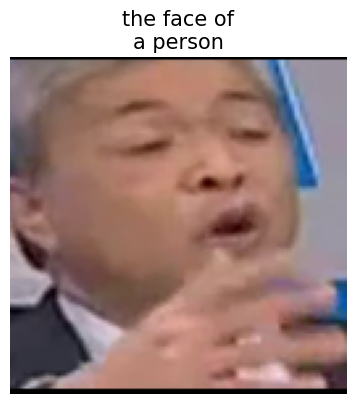

In [31]:
plt.figure(figsize=(20, 10))


ax = plt.subplot(1, 4, 1)
plt.imshow((sample_batch["images"][0] + 1) / 2)

text = tokenizer.decode(sample_batch["tokens"][0].numpy().squeeze())
text = text.replace("<|startoftext|>", "")
text = text.replace("<|endoftext|>", "")
text = "\n".join(wrap(text, 12))
plt.title(text, fontsize=15)

plt.axis("off")


In [32]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


In [33]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = False
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:
epochs = 10
if(epochs > 0):
    ckpt_path = "finetuned_stable_diffusion.h5"
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        save_weights_only=True,
        monitor="loss",
        mode="min",
    )
    diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])


Epoch 1/10
Instructions for updating:
Use fn_output_signature instead


2023-03-29 12:33:54.388737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-29 12:33:57.002693: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ef10d454ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 12:33:57.002716: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-03-29 12:33:57.025182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 12:33:57.241540: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-29 12:34:15.007095: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.05GiB with freed_by_count=0. The caller 

50000/50000 [==============================] - 31039s 618ms/step - loss: 0.1265
Epoch 2/10
50000/50000 [==============================] - 30935s 619ms/step - loss: 0.1171
Epoch 3/10
50000/50000 [==============================] - 31587s 632ms/step - loss: 0.1132
Epoch 4/10
41475/50000 [=======================>......] - ETA: 1:30:29 - loss: 0.1101

: 

: 

In [34]:

weights_path = "finetuned_stable_diffusion.h5"
img_height = img_width = 128
pokemon_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
# We just reload the weights of the fine-tuned diffusion model.
pokemon_model.diffusion_model.load_weights(weights_path)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
a.shape

In [74]:
prompt = "the face of a person " #"Hello Kitty", "A pokemon with red eyes"]
#prompts = ["Yoda", "Hello Kitty", "A pokemon with red eyes"]
images_to_generate = 4
outputs = {}
encoded_text = pokemon_model.encode_text(prompt)
encoded_text = encoded_text[:,:-1,:]
emb = np.expand_dims(a[8000], axis=1)

In [ ]:

emb.shape

In [ ]:
encoded_text.shape

In [75]:
encoded_text = np.concatenate((encoded_text, emb), axis=1)

In [76]:

generated_images = pokemon_model.generate_image(
     encoded_text = encoded_text, batch_size=images_to_generate, unconditional_guidance_scale=40
)
outputs.update({prompt: generated_images})


50/50 [==============================] - 21s 384ms/step


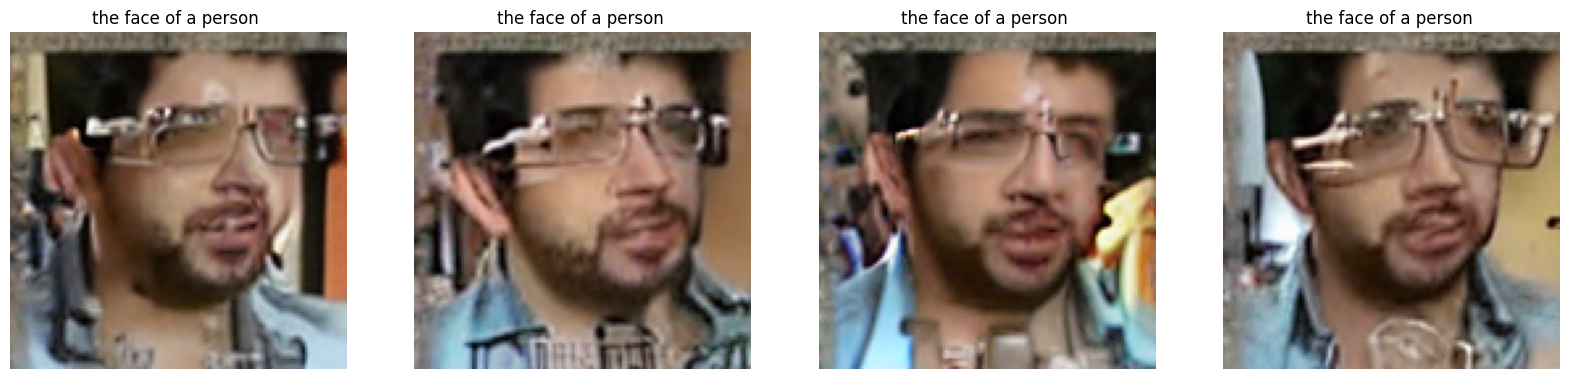

In [77]:
def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)
